In [2]:
import json
import requests
import websockets
from requests import Session
import pandas as pd
import time
import hashlib
import hmac
import base64
import sys
import numpy as np
import matplotlib.pyplot as plt
inf = sys.maxsize

In [3]:
spotPrices = []
futurePrices = []
differences = []

In [4]:
url = 'https://api.kucoin.com/api/v1/bullet-public'

In [5]:
x = requests.post(url)

In [6]:
cjson = json.loads(x.text)

In [7]:
endpoint = cjson['data']['instanceServers'][0]['endpoint']
token = cjson['data']['token']

In [8]:
multi = {"id": "1Jpg30DEdU", "type": "openTunnel", "newTunnelId": "bt1", "response": False}
# command used to open tunnel

In [9]:
multi_spotEth = {"id": "1JpoPamgFM",
             "type": "subscribe",
             "topic": "/market/ticker:ETH-USDT",
             "tunnelId": "bt1", "response": False}
# subscriptions to websocket with tunnelID attached

In [10]:
multi_futureEth = {"id": 1545910660740,                          
                "type": "subscribe",
                "topic": "/contractMarket/tickerV2:ETHUSDTM",
                "tunnelId": "bt1", "response": False}
# subscriptions to websocket with tunnelID attached

In [11]:
import sys
sys.path.append('..')
import classified

# for future api
fapi_passphrase = classified.FPASSPHRASE
fapi_key = classified.FKEY
fapi_secret = classified.FSECRET
# for spot api
api_passphrase = classified.SPASSPHRASE
api_key = classified.SKEY
api_secret = classified.SSECRET

session = Session()

In [12]:
def auth(method, endpoint):
    now = int(time.time() * 1000)
    str_to_sign = str(now) + method.upper() + endpoint
    signature = base64.b64encode(
        hmac.new(api_secret.encode('utf-8'), str_to_sign.encode('utf-8'), hashlib.sha256).digest())
    passphrase = base64.b64encode(hmac.new(api_secret.encode('utf-8'), api_passphrase.encode('utf-8'), hashlib.sha256).digest())
    headers = {
        "KC-API-SIGN": signature,
        "KC-API-TIMESTAMP": str(now),
        "KC-API-KEY": api_key,
        "KC-API-PASSPHRASE": passphrase,
        "KC-API-KEY-VERSION": '2',
        "Content-Type": "application/json"
    }
    return headers

In [13]:
class executeTrade:
    
    def spotOrder(self, side, symbol, price, size):
        url = 'https://api.kucoin.com/api/v1/orders'
        now = int(time.time() * 1000)
        data = {"clientOid": "01", "side": side, "symbol": symbol, "price": price,"size": size}
        data_json = json.dumps(data)
        str_to_sign = str(now) + 'POST' + '/api/v1/orders' + data_json
        signature = base64.b64encode(
            hmac.new(api_secret.encode('utf-8'), str_to_sign.encode('utf-8'), hashlib.sha256).digest())
        passphrase = base64.b64encode(
            hmac.new(api_secret.encode('utf-8'), api_passphrase.encode('utf-8'), hashlib.sha256).digest())
        headers = {
            "KC-API-SIGN": signature,
            "KC-API-TIMESTAMP": str(now),
            "KC-API-KEY": api_key,
            "KC-API-PASSPHRASE": passphrase,
            "KC-API-KEY-VERSION": '2',
            "Content-Type": "application/json" # specifying content type or using json=data in request
        }
        response = session.post(url, headers=headers, data=data_json)
        print(response.status_code)
        print(response.json())
        
    def futureOrder(self, side, symbol, leverage, price, size):
        url = 'https://api-futures.kucoin.com/api/v1/orders'
        now = int(time.time() * 1000)
        data = {"clientOid": "02", "side": side, "symbol": symbol, "leverage": leverage, "price": price,"size": size}
        data_json = json.dumps(data)
        str_to_sign = str(now) + 'POST' + '/api/v1/orders' + data_json
        signature = base64.b64encode(
            hmac.new(fapi_secret.encode('utf-8'), str_to_sign.encode('utf-8'), hashlib.sha256).digest())
        passphrase = base64.b64encode(
            hmac.new(fapi_secret.encode('utf-8'), fapi_passphrase.encode('utf-8'), hashlib.sha256).digest())
        headers = {
            "KC-API-SIGN": signature,
            "KC-API-TIMESTAMP": str(now),
            "KC-API-KEY": fapi_key,
            "KC-API-PASSPHRASE": passphrase,
            "KC-API-KEY-VERSION": '2',
            "Content-Type": "application/json" # specifying content type or using json=data in request
        }
        response = session.post(url, headers=headers, data=data_json)
        print(response.status_code)
        print(response.json())
        
trade = executeTrade()

In [14]:
class openClosePostion:
    
#     def arbOpen(self, spotPrice, futurePrice):
#         trade.spotOrder("buy", "ETH-USDT", spotPrice, "0.01")
#         trade.futureOrder("sell", "ETHUSDTM", "1", futurePrice, "1")
#         #trade.marekt("buy/sell", "tradingPair", "leverage", "limitPrice", "size")
    
    def arbOpen(self):
        trade.spotOrder("buy", "ETH-USDT", "500", "0.01")
        trade.futureOrder("sell", "ETHUSDTM", "1", "986", "1")
        #trade.marekt("buy/sell", "tradingPair", "leverage", "limitPrice", "size")
        
    def arbClose(self):
        trade.spotOrder("sell", "ETH-USDT", spotPrice, "0.01")
        trade.futureOrder("buy", "ETHUSDTM", "1", futurePrice, "1")
        #trade.marekt("buy/sell", "tradingPair", "leverage", "limitPrice", "size")
        
arb = openClosePostion()

In [15]:
spotPrices.clear()
futurePrices.clear()
async with websockets.connect(endpoint+"?token="+token) as conn:
    await conn.send(json.dumps(multi))  # initial open tunel command
    res = await conn.recv()
    
    await conn.send(json.dumps(multi_spotEth)) # send tunnel subscription
    res = await conn.recv()
    await conn.send(json.dumps(multi_futureEth))  # send tunnel subscription
    res = await conn.recv()
    
    counter = 0
    spotPrice = 0
    futurePrice = 0
    while True and counter < inf:
        res = await conn.recv()
        vals = json.loads(res)

        if (vals['topic']) == '/contractMarket/tickerV2:ETHUSDTM':
#             print(f"Future Price is: {vals['data']['bestAskPrice']}")
            futurePrice = float(vals['data']['bestAskPrice'])
            futurePrices.append(futurePrice)

        elif (vals['topic']) == '/market/ticker:ETH-USDT':
#             print(f"Spot Price is: {vals['data']['bestAsk']}")
            spotPrice = float(vals['data']['bestAsk'])
            spotPrices.append(spotPrice)
        
        difference = spotPrice - futurePrice
        differences.append(difference)
        print(spotPrice - futurePrice)
        print(counter)
        
        # OPEN POSTION
        if spotPrice - futurePrice > 1 and futurePrice != 0 and spotPrice != 0:
            print('Long Future and Short Spot')
            
        elif futurePrice - spotPrice > 1 and futurePrice != 0 and spotPrice != 0:
            print('Long Spot and Short Future')
#             arb.arbOpen(spotPrice, futurePrice)
            
            
        counter += 1
    eth_tunnel = {"id": "1JpoPamgFM", "type": "closeTunnel", "tunnelId": "bt1", "response": False}            
    btc_tunnel = {"id": "1JpoPamgFN", "type": "closeTunnel", "tunnelId": "bt1", "response": False}
    await conn.send(json.dumps(eth_tunnel))
    await conn.send(json.dumps(btc_tunnel))
    await conn.close()

1590.41
0
0.36000000000012733
1
0.36000000000012733
2
0.36000000000012733
3
0.4600000000000364
4
0.4600000000000364
5
0.4600000000000364
6
0.4600000000000364
7
0.4600000000000364
8
0.4600000000000364
9
0.4600000000000364
10
0.4600000000000364
11
0.4600000000000364
12
0.4600000000000364
13
0.4600000000000364
14
0.4600000000000364
15
0.4600000000000364
16
0.4600000000000364
17
0.4600000000000364
18
0.4600000000000364
19
0.4600000000000364
20
0.4600000000000364
21
0.4600000000000364
22
0.4600000000000364
23
0.4600000000000364
24
0.4600000000000364
25
0.4600000000000364
26
0.4600000000000364
27
0.4600000000000364
28
0.4600000000000364
29
0.4600000000000364
30
-0.03999999999996362
31
0.2599999999999909
32
0.05999999999994543
33
0.2599999999999909
34
0.20000000000004547
35
0.20000000000004547
36
0.19000000000005457
37
0.19000000000005457
38
0.19000000000005457
39
0.19000000000005457
40
0.19000000000005457
41
0.19000000000005457
42
0.19000000000005457
43
0.19000000000005457
44
0.1900000000000

0.44000000000005457
307
0.44000000000005457
308
0.44000000000005457
309
0.44000000000005457
310
0.44000000000005457
311
0.44000000000005457
312
0.44000000000005457
313
0.44000000000005457
314
0.3400000000001455
315
0.3400000000001455
316
0.290000000000191
317
0.290000000000191
318
0.290000000000191
319
0.290000000000191
320
0.290000000000191
321
0.44000000000005457
322
0.44000000000005457
323
0.44000000000005457
324
0.44000000000005457
325
0.44000000000005457
326
0.44000000000005457
327
0.4900000000000091
328
0.4900000000000091
329
0.4900000000000091
330
0.540000000000191
331
0.540000000000191
332
0.540000000000191
333
0.540000000000191
334
0.540000000000191
335
0.540000000000191
336
0.540000000000191
337
0.540000000000191
338
0.540000000000191
339
0.540000000000191
340
0.540000000000191
341
0.540000000000191
342
0.540000000000191
343
0.540000000000191
344
0.540000000000191
345
0.540000000000191
346
0.540000000000191
347
0.540000000000191
348
0.540000000000191
349
0.540000000000191
350

CancelledError: 

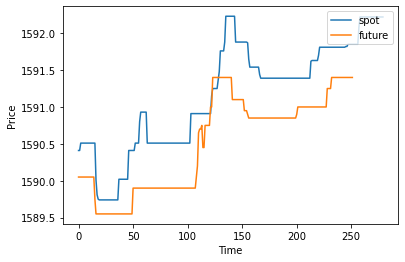

In [16]:
plt.plot(spotPrices, label="spot")
plt.plot(futurePrices, label="future")
plt.ylabel('Price')
plt.xlabel('Time')
plt.legend(loc="upper right")
plt.show()

In [17]:
differences = [i for i in differences if i > 0]

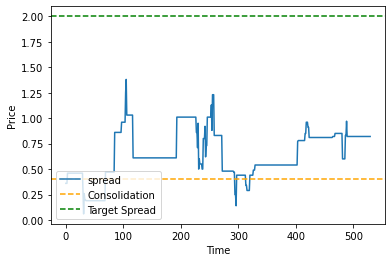

In [18]:
differences.pop(0)
plt.plot(differences, label="spread")
plt.axhline(y=0.4, color='orange', linestyle='--', label="Consolidation")
plt.axhline(y=2, color='green', linestyle='--', label="Target Spread")
plt.ylabel('Price')
plt.xlabel('Time')
plt.legend(loc="lower left")
plt.show()